## Convert ground truth images to flat list for baseline eval

In [2]:
import os
import shutil
import glob
from PIL import Image

# Input parameters
source_root = "sampled"         
target_dir = "ground_truth"             # where to copy renamed ground truth images

# Create the output directory if needed
os.makedirs(target_dir, exist_ok=True)

# Copy images ending with _photo.* into ground_truth/{id}.png
count = 0
for id_folder in os.listdir(source_root):
    full_path = os.path.join(source_root, id_folder)
    if not os.path.isdir(full_path):
        continue

    matches = glob.glob(os.path.join(full_path, "*_photo.*"))
    if not matches:
        print(f"Warning: No _photo image in {id_folder}")
        continue

    src_path = matches[0]  # take the first matching _photo image
    img = Image.open(src_path).convert("RGB")
    dst_path = os.path.join(target_dir, f"{id_folder}.png")
    img.save(dst_path)
    count += 1

count


1250

## Filter out baseline val split; reindex to hf index

In [12]:
# import os
# import json
# import shutil

# ip2p_root = "ip2p/results"

# # Load dataset.json
# with open('dataset.json') as f:
#     dataset = json.load(f)

# # Create mapping from edit_text to original_id
# text_to_id = {item['edit_text']: item['id'].split('_')[0] for item in dataset}

# # Create output directory
# os.makedirs('baseline_predictions_reindexed', exist_ok=True)

# # hf ids to original ids
# hf_to_original = {}

# # Loop through IP2P results
# for hf_id in os.listdir(ip2p_root):
#     subdir = os.path.join(ip2p_root, hf_id)

#     # Read prompt.txt
#     prompt_file = os.path.join(subdir, 'prompt.txt')
        
#     with open(prompt_file) as f:
#         prompt = f.read().strip()
    
#     # Find original ID from dataset
#     if prompt not in text_to_id:
#         raise ValueError(f"Could not find prompt in dataset for ID {hf_id}.")
        
#     original_id = text_to_id[prompt]
    
#     # Copy and rename file
#     src = os.path.join('baseline_predictions', f'{original_id}.png')
#     dst = os.path.join('baseline_predictions_reindexed', f'{hf_id}.png')
    
#     if not os.path.exists(src):
#         raise ValueError(f"Missing baseline prediction for ID {original_id}.")
        
#     shutil.copy2(src, dst)
#     hf_to_original[hf_id] = original_id

## Convert to a flat list of {id}.png

In [11]:
import os
from PIL import Image

source_root = "ip2p/results"
target_dir = "ip2p_flat"
os.makedirs(target_dir, exist_ok=True)

converted = 0
for id_folder in os.listdir(source_root):
    subdir = os.path.join(source_root, id_folder)
    if not os.path.isdir(subdir):
        continue

    edited_path = os.path.join(subdir, "edited.png")
    if not os.path.exists(edited_path):
        print(f"Missing edited.png for ID {id_folder}, skipping.")
        continue

    try:
        img = Image.open(edited_path).convert("RGB")
        save_path = os.path.join(target_dir, f"{id_folder}.png")
        img.save(save_path)
        converted += 1
    except Exception as e:
        print(f"Failed to process {id_folder}: {e}")

converted


118

In [14]:
source_root = "outputs_sketch_and_prompt/val_preds"
target_dir = "sketch_and_prompt_flat"
os.makedirs(target_dir, exist_ok=True)

converted = 0
for id_folder in os.listdir(source_root):
    subdir = os.path.join(source_root, id_folder)
    if not os.path.isdir(subdir):
        continue

    edited_path = os.path.join(subdir, "edited.png")
    if not os.path.exists(edited_path):
        print(f"Missing edited.png for ID {id_folder}, skipping.")
        continue

    try:
        img = Image.open(edited_path).convert("RGB")
        save_path = os.path.join(target_dir, f"{id_folder}.png")
        img.save(save_path)
        converted += 1
    except Exception as e:
        print(f"Failed to process {id_folder}: {e}")

converted

118

## FOR BASELINE ONLY (uses original ids): ENTIRE IMG

In [34]:

import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from IPython.display import display

# ── USER PARAMETERS ────────────────────────────────────────────────────────────
pred_dir   = "baseline_predictions"       # <— update to your predictions folder
target_dir = "ground_truth"      # <— update to your ground-truth folder
bbox_file  = None                # <— e.g. "bboxes.json", or None
# ────────────────────────────────────────────────────────────────────────────────

# Metric definitions
def compute_mse(img1, img2):
    return float(np.mean((img1.astype(np.float32) - img2.astype(np.float32))**2))

def compute_hist_int(img1, img2, bins=256):
    ints = []
    for ch in range(3):
        h1 = cv2.calcHist([img1],[ch],None,[bins],[0,256]); h1 /= h1.sum()
        h2 = cv2.calcHist([img2],[ch],None,[bins],[0,256]); h2 /= h2.sum()
        ints.append(float(np.minimum(h1,h2).sum()))
    return float(np.mean(ints))

def crop(img, bbox):
    x,y,w,h = bbox; return img[y:y+h, x:x+w]

# Load optional bboxes
bboxes = {}
if bbox_file and os.path.exists(bbox_file):
    bboxes = pd.read_json(bbox_file, typ='series').to_dict()

# Gather results
rows = []
for fn in sorted(os.listdir(pred_dir)):
    if not fn.lower().endswith(('.png','.jpg','.jpeg')): continue
    id_ = os.path.splitext(fn)[0]
    pth_pred   = os.path.join(pred_dir, fn)
    pth_target = os.path.join(target_dir, fn)
    if not os.path.exists(pth_target):
        print(f"Skipping {id_}: no target found")
        continue

    im_pred   = np.array(Image.open(pth_pred).convert("RGB"))
    im_target = np.array(Image.open(pth_target).convert("RGB"))

    if id_ in bboxes:
        im_pred   = crop(im_pred,   bboxes[id_])
        im_target = crop(im_target, bboxes[id_])

    # match shapes
    if im_pred.shape != im_target.shape:
        im_target = cv2.resize(im_target, (im_pred.shape[1], im_pred.shape[0]))

    mse = compute_mse(im_pred, im_target)
    hi  = compute_hist_int(im_pred, im_target)
    rows.append({"id": id_, "mse": mse, "hist_inter": hi})

# Create DataFrame
df = pd.DataFrame(rows)
df = df.sort_values("id").reset_index(drop=True)

# Display inline
display(df)

print(f"Processed {len(df)} pairs")
print(f"Average MSE: {df['mse'].mean():.4f}")
print(f"Average Hist. Intersection: {df['hist_inter'].mean():.4f}")


,id,mse,hist_inter
0,0,1814.296753,0.779984
1,1,6218.982910,0.559774
2,10,698.564636,0.881104
3,100,855.649170,0.929749
4,101,2112.517334,0.914861
...,...,...,...
100,89,3300.976807,0.481222
101,9,2186.909424,0.417114
102,93,1653.345215,0.831609
103,94,783.552979,0.933736


Processed 105 pairs
Average MSE: 3464.4583
Average Hist. Intersection: 0.7878


#### FOR BASELINE ONLY (uses original ids): BBOX

In [35]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from IPython.display import display

# ── USER PARAMETERS ────────────────────────────────────────────────────────────
pred_dir   = "baseline_predictions"                  # folder of {id}.png predictions
target_dir = "ground_truth"                          # folder of {id}.png ground-truth
bbox_json_path = "multi-modal-image-edit/groundingSAM/grounding.json"
# ────────────────────────────────────────────────────────────────────────────────

def compute_mse(img1, img2):
    return float(np.mean((img1.astype(np.float32) - img2.astype(np.float32))**2))

def compute_hist_int(img1, img2, bins=256):
    ints = []
    for ch in range(3):
        h1 = cv2.calcHist([img1],[ch],None,[bins],[0,256]); h1 /= h1.sum()
        h2 = cv2.calcHist([img2],[ch],None,[bins],[0,256]); h2 /= h2.sum()
        ints.append(float(np.minimum(h1,h2).sum()))
    return float(np.mean(ints))

def crop(img, bbox):
    x1, y1, x2, y2 = bbox
    x1, y1 = int(round(x1)), int(round(y1))
    x2, y2 = int(round(x2)), int(round(y2))
    return img[y1:y2, x1:x2]

# ── LOAD BBOXES ────────────────────────────────────────────────────────────────
bboxes = {}
if os.path.exists(bbox_json_path):
    with open(bbox_json_path, 'r') as f:
        raw = json.load(f)
        for id_, entry in raw.items():
            bbox = entry.get("bbox")
            if bbox and len(bbox) == 4:
                bboxes[id_] = bbox
    print(f"Loaded {len(bboxes)} bounding boxes.")
else:
    print("Warning: bounding box file not found.")

# ── PROCESS ALL IMAGE PAIRS ────────────────────────────────────────────────────
rows = []
for fn in sorted(os.listdir(pred_dir)):
    if not fn.lower().endswith(('.png','.jpg','.jpeg')):
        continue
    id_ = os.path.splitext(fn)[0]
    pred_path = os.path.join(pred_dir, fn)
    gt_path   = os.path.join(target_dir, fn)

    if not os.path.exists(gt_path):
        print(f"Skipping {id_}: no ground-truth image found")
        continue

    im_pred   = np.array(Image.open(pred_path).convert("RGB"))
    im_target = np.array(Image.open(gt_path).convert("RGB"))

    if id_ in bboxes:
        im_pred   = crop(im_pred,   bboxes[id_])
        im_target = crop(im_target, bboxes[id_])

    if im_pred.shape != im_target.shape:
        im_target = cv2.resize(im_target, (im_pred.shape[1], im_pred.shape[0]))

    mse = compute_mse(im_pred, im_target)
    hi  = compute_hist_int(im_pred, im_target)
    rows.append({"id": id_, "mse": mse, "hist_inter": hi})

# ── DISPLAY RESULTS ────────────────────────────────────────────────────────────
df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
display(df)

print(f"\nProcessed {len(df)} image pairs")
print(f"Average MSE: {df['mse'].mean():.4f}")
print(f"Average Histogram Intersection: {df['hist_inter'].mean():.4f}")


Loaded 1176 bounding boxes.


,id,mse,hist_inter
0,0,6544.003418,0.583741
1,1,7811.325195,0.471966
2,10,3354.538330,0.720381
3,100,3813.794678,0.709333
4,101,5070.483398,0.807526
...,...,...,...
100,89,8393.933594,0.522609
101,9,12219.265625,0.508528
102,93,4512.258789,0.740361
103,94,3767.758301,0.764932



Processed 105 image pairs
Average MSE: 6827.4852
Average Histogram Intersection: 0.6621


## FOR HF INDEXING: ENTIRE IMG 
### I included visualization to make sure I was matching up the right images

Loaded HF dataset split 'val' with 118 entries.


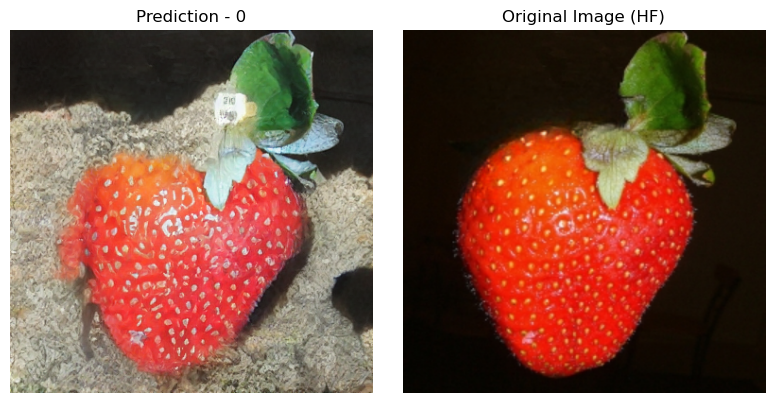

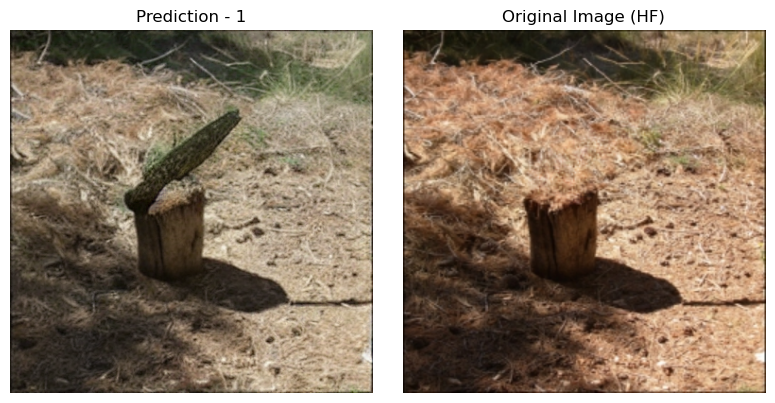

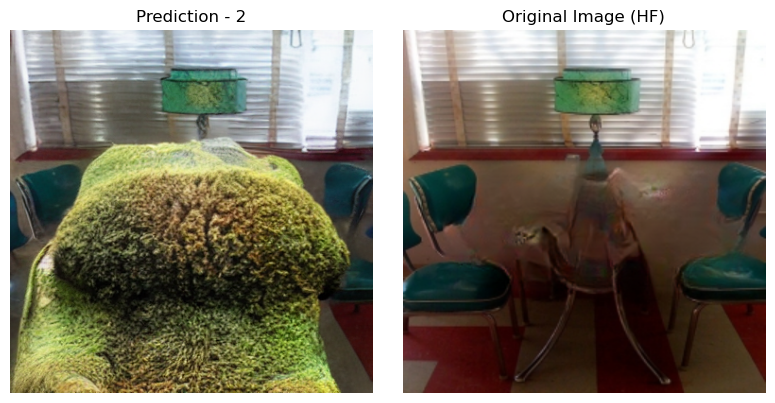

,id,mse,hist_inter
0,0,8648.452148,0.347939
1,1,732.493713,0.858552
2,10,982.669189,0.770440
3,100,7007.674316,0.613944
4,101,13529.871094,0.149100
...,...,...,...
113,95,2767.946533,0.456468
114,96,1480.504395,0.565375
115,97,11732.797852,0.144253
116,98,3502.589355,0.558151



Compared 118 image pairs
Average MSE: 3533.7243
Average Histogram Intersection: 0.6155


In [36]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from datasets import load_dataset
from IPython.display import display

# ── USER PARAMETERS ────────────────────────────────────────────────────────────
pred_dir = "notext_predictions"     # local directory of {id}.png predictions
split = "val"                       # HF split: "train" or "validation"
max_visualize = 3                         # How many image pairs to preview inline
dataset_name = "anya-ji/multi-modal-image-edit"
# ────────────────────────────────────────────────────────────────────────────────

def compute_mse(img1, img2):
    return float(np.mean((img1.astype(np.float32) - img2.astype(np.float32))**2))

def compute_hist_int(img1, img2, bins=256):
    ints = []
    for ch in range(3):
        h1 = cv2.calcHist([img1],[ch],None,[bins],[0,256]); h1 /= h1.sum()
        h2 = cv2.calcHist([img2],[ch],None,[bins],[0,256]); h2 /= h2.sum()
        ints.append(float(np.minimum(h1,h2).sum()))
    return float(np.mean(ints))

# ── Load HF Dataset ────────────────────────────────────────────────────────────
hf_data = load_dataset(dataset_name, split=split)
print(f"Loaded HF dataset split '{split}' with {len(hf_data)} entries.")
# ── Run Evaluation ─────────────────────────────────────────────────────────────
rows = []
visualized = 0

for idx, item in enumerate(hf_data):
    pred_path = os.path.join(pred_dir, f"{idx}.png")
    if not os.path.exists(pred_path):
        continue

    im_pred = np.array(Image.open(pred_path).convert("RGB"))
    im_target = np.array(item["original_image"].convert("RGB"))

    # Resize if needed
    if im_pred.shape != im_target.shape:
        im_target = cv2.resize(im_target, (im_pred.shape[1], im_pred.shape[0]))

    mse = compute_mse(im_pred, im_target)
    hi  = compute_hist_int(im_pred, im_target)
    rows.append({"id": str(idx), "mse": mse, "hist_inter": hi})

    # ── Visualization ────────────────────────────────────────────────
    if visualized < max_visualize:
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(im_pred)
        axs[0].set_title(f"Prediction - {idx}")
        axs[1].imshow(im_target)
        axs[1].set_title("Original Image (HF)")
        for ax in axs:
            ax.axis("off")
        plt.tight_layout()
        plt.show()
        visualized += 1

# ── Summary Table ──────────────────────────────────────────────────────────────
df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
display(df)

print(f"\nCompared {len(df)} image pairs")
print(f"Average MSE: {df['mse'].mean():.4f}")
print(f"Average Histogram Intersection: {df['hist_inter'].mean():.4f}")


## FOR HF INDEXING: BBOX ONLY


In [26]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
import cv2
from datasets import load_dataset
from IPython.display import display

# ── USER PARAMETERS ────────────────────────────────────────────────────────────
pred_dir = "notext_predictions"   # predictions saved as {row_id}.png
bbox_json_path = "multi-modal-image-edit/groundingSAM/grounding.json"
hf_split = "val"
dataset_name = "anya-ji/multi-modal-image-edit"
# ────────────────────────────────────────────────────────────────────────────────

def compute_mse(img1, img2):
    return float(np.mean((img1.astype(np.float32) - img2.astype(np.float32))**2))

def compute_hist_int(img1, img2, bins=256):
    ints = []
    for ch in range(3):
        h1 = cv2.calcHist([img1], [ch], None, [bins], [0, 256]); h1 /= h1.sum()
        h2 = cv2.calcHist([img2], [ch], None, [bins], [0, 256]); h2 /= h2.sum()
        ints.append(float(np.minimum(h1, h2).sum()))
    return float(np.mean(ints))

def crop(img, bbox):
    x1, y1, x2, y2 = bbox
    x1, y1 = int(round(x1)), int(round(y1))
    x2, y2 = int(round(x2)), int(round(y2))
    return img[y1:y2, x1:x2]

# ── LOAD HUGGING FACE DATASET ──────────────────────────────────────────────────
hf_data = load_dataset(dataset_name, split=hf_split)
print(f"Loaded HF split '{hf_split}' with {len(hf_data)} examples.")

# ── LOAD BBOXES FROM JSON ──────────────────────────────────────────────────────
bboxes = {}
if os.path.exists(bbox_json_path):
    with open(bbox_json_path, "r") as f:
        raw = json.load(f)
        for id_, entry in raw.items():
            bbox = entry.get("bbox")
            if bbox and len(bbox) == 4:
                bboxes[id_] = bbox
    print(f"Loaded {len(bboxes)} bounding boxes.")
else:
    print("Warning: bounding box file not found.")

# ── PROCESS ALL PREDICTIONS ────────────────────────────────────────────────────
rows = []
for i, item in enumerate(hf_data):
    pred_path = os.path.join(pred_dir, f"{i}.png")
    if not os.path.exists(pred_path):
        continue

    im_pred = np.array(Image.open(pred_path).convert("RGB"))
    im_target = np.array(item["original_image"].convert("RGB"))

    if str(i) in bboxes:
        im_pred   = crop(im_pred,   bboxes[str(i)])
        im_target = crop(im_target, bboxes[str(i)])

    if im_pred.shape != im_target.shape:
        im_target = cv2.resize(im_target, (im_pred.shape[1], im_pred.shape[0]))

    mse = compute_mse(im_pred, im_target)
    hi = compute_hist_int(im_pred, im_target)
    rows.append({"id": i, "mse": mse, "hist_inter": hi})

# ── DISPLAY RESULTS ────────────────────────────────────────────────────────────
df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
display(df)

print(f"\nCompared {len(df)} image pairs from HF dataset")
print(f"Average MSE: {df['mse'].mean():.4f}")
print(f"Average Histogram Intersection: {df['hist_inter'].mean():.4f}")


Loaded HF split 'val' with 118 examples.
Loaded 1176 bounding boxes.


,id,mse,hist_inter
0,0,6145.700684,0.551115
1,1,4758.766602,0.807550
2,2,6225.979004,0.570261
3,3,5686.021973,0.725853
4,4,9758.526367,0.321759
...,...,...,...
113,113,4031.655762,0.550762
114,114,952.209106,0.475889
115,115,6153.694824,0.517023
116,116,1971.359131,0.716859



Compared 118 image pairs from HF dataset
Average MSE: 7007.3070
Average Histogram Intersection: 0.5065


# Cosine similarity using CLIP image embeddings

In [13]:
import torch
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from PIL import Image
from transformers import CLIPModel, CLIPProcessor
_model = CLIPModel.from_pretrained('openai/clip-vit-large-patch14')

def get_clip_embeddings(img):   
    image_processor = Compose([
        Resize(size=224, interpolation=Image.BICUBIC),
        CenterCrop(size=(224, 224)),
        lambda img: img.convert('RGB'),
        ToTensor(),
        Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
    ])
    inputs=dict(pixel_values=image_processor(img).unsqueeze(0))
    with torch.no_grad():
        vision_outputs = _model.vision_model(**inputs)
        image_embeds = vision_outputs[1]
        image_embeds = _model.visual_projection(image_embeds)
        image_embeds = image_embeds / image_embeds.norm(dim=-1, keepdim=True)
    return image_embeds.squeeze(0)

/home/anyaji/anaconda3/envs/cv1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
from datasets import load_dataset
dataset = load_dataset("anya-ji/multi-modal-image-edit", split="val")
targets = [item['edited_image'] for item in dataset]

  0%|          | 0/118 [00:00<?, ?it/s]

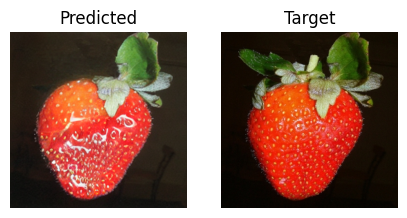

  1%|          | 1/118 [00:00<01:02,  1.87it/s]

0.8353325128555298


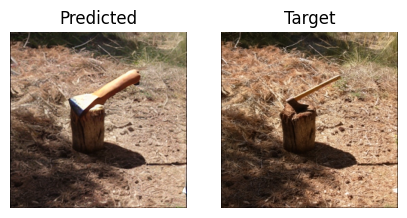

  2%|▏         | 2/118 [00:01<00:59,  1.96it/s]

0.8661762475967407


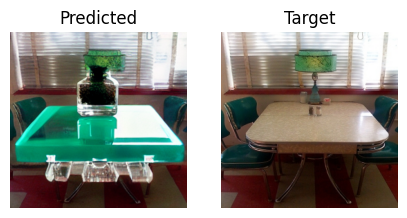

  3%|▎         | 3/118 [00:01<00:59,  1.92it/s]

0.7736129760742188


100%|██████████| 118/118 [00:38<00:00,  3.05it/s]


,id,clip_sim
0,0,0.835333
1,1,0.866176
2,2,0.773613
3,3,0.926895
4,4,0.944740
...,...,...
113,113,0.936480
114,114,0.907111
115,115,0.895266
116,116,0.926877



Average CLIP similarity for sketch_and_prompt_flat: 0.8835


In [28]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pandas as pd

predictions_dir = "sketch_and_prompt_flat"
rows = []

for i in tqdm(range(len(targets))):
    pred_path = os.path.join(predictions_dir, f"{i}.png")
    pred_img = Image.open(pred_path)
    target_img = targets[i]
    
    pred_emb = get_clip_embeddings(pred_img)
    target_emb = get_clip_embeddings(target_img)
    
    cos_sim = torch.nn.functional.cosine_similarity(pred_emb.unsqueeze(0), target_emb.unsqueeze(0))

    if i < 3:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,3))
        ax1.imshow(pred_img)
        ax1.set_title('Predicted')
        ax1.axis('off')
        ax2.imshow(target_img)
        ax2.set_title('Target') 
        ax2.axis('off')
        plt.show()
        print(cos_sim.item())
    
    rows.append({
        "id": i,
        "clip_sim": cos_sim.item()
    })

clip_df = pd.DataFrame(rows)
display(clip_df)
print(f"\nAverage CLIP similarity for {predictions_dir}: {clip_df['clip_sim'].mean():.4f}")


# FID

refer to: https://github.com/mseitzer/pytorch-fid

example: `python -m pytorch_fid ground_truth sketch_and_prompt_flat`

In [29]:
# Generate target directory
import os
import shutil

# Create target directory
target_dir = "ground_truth"
os.makedirs(target_dir, exist_ok=True)
for i in tqdm(range(len(targets))):
    target_img = targets[i]
    target_img.save(os.path.join(target_dir, f"{i}.png"))


100%|██████████| 118/118 [00:02<00:00, 45.08it/s]
